<a href="https://colab.research.google.com/github/VivekSalwan2000/Logistic-Regression-Diabetes/blob/main/COSC3P96_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:- Vivek Salwan**

**Student ID:- 6951826**

**Problem description:-** Develop a logistic regression classifier to predict whether a patient has diabetes, using the Pima Indians Diabetes Dataset. Implement the model from scratch using only basic Python libraries, such as NumPy and pandas, to gain a deeper understanding of the underlying mathematics and the gradient descent optimization technique.

After constructing and evaluating our custom model using metrics like accuracy, precision, recall, F1-score, and AUC, we compare its performance to that of a logistic regression model built with scikit-learn.

Link for the Project: https://colab.research.google.com/drive/15PwupYkLvKTngIqQjcmBR1yhqmZ9ZCYF?usp=sharing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#For Final Comaprison Only
from sklearn.linear_model import LogisticRegression

**Load and preview the Pima Indians Diabetes dataset from the URL**

In [ ]:
# Define the data URL and column names
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
           "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

# Load the dataset into a pandas DataFrame
data = pd.read_csv(data_url, header=None, names=columns)
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Replacing invalid zero values with NaN and impute missing values with column medians, then display missing value counts.**

In [ ]:
# List of columns where 0 is an invalid value
cols_invalid_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with NaN and then impute with the column median
for col in cols_invalid_zero:
    data[col] = data[col].replace(0, np.nan)
    median_val = data[col].median()
    data[col] = data[col].fillna(median_val)

print("\nMissing values per column after imputation:")
data.isnull().sum()


Missing values per column after imputation:


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


**Extract input features (X) and target variable (y) from the dataset.**

In [ ]:
# Separate input features (X) and target (y)
X = data.drop("Outcome", axis=1).values   # shape: (m, n)
y = data["Outcome"].values                # shape: (m,)

**Manually shuffle and split the dataset into 80% training and 20% testing sets.**

In [ ]:
def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    """
    Splits the data into training and testing sets.
    """
    if random_state is not None:
        np.random.seed(random_state)
    m = X.shape[0]
    indices = np.random.permutation(m)
    test_count = int(m * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)


**Standardize the training data and apply the same mean and standard deviation to the test data.**

In [ ]:
def standardize(X, mean=None, std=None):
    """
    Standardizes the dataset.
    If mean and std are not provided, they are computed from X.
    """
    if mean is None:
        mean = np.mean(X, axis=0)
    if std is None:
        std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

# Standardize the training data and use the same parameters to transform test data
X_train_std, train_mean, train_std = standardize(X_train)
X_test_std, _, _ = standardize(X_test, train_mean, train_std)


**Add a bias column (ones) to the standardized training and testing data to account for the intercept.**

In [ ]:
def add_bias(X):
    """
    Adds a column of ones to X for the bias term.
    """
    m = X.shape[0]
    bias = np.ones((m, 1))
    return np.hstack([bias, X])

X_train_bias = add_bias(X_train_std)
X_test_bias = add_bias(X_test_std)


**Sigmoid Function:**  
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$


In [ ]:
def sigmoid(z):
    """
    Computes the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))


**Binary Cross-Entropy Cost Function:**  
$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \Biggl[ y^{(i)} \log\Bigl( h_\theta\bigl(x^{(i)}\bigr) \Bigr) + \Bigl( 1 - y^{(i)} \Bigr) \log\Bigl( 1 - h_\theta\bigl(x^{(i)}\bigr) \Bigr) \Biggr]
$$


In [ ]:
def compute_cost(X, y, weights):
    """
    Computes the binary cross-entropy cost.
    """
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    epsilon = 1e-7  # To prevent log(0)
    cost = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return cost


**Gradient Descent for Logistic Regression**

The weights are updated iteratively using the following rule:

$$
\theta := \theta - \alpha \frac{1}{m} X^T \left( \sigma(X\theta) - y \right)
$$

This code implements gradient descent for logistic regression by iteratively updating the weights: it computes predictions using the sigmoid function, calculates the gradient of the binary cross-entropy loss, and updates the weights accordingly. The process tracks the cost over iterations and stops early if convergence is detected, returning the final weights and cost history.


In [ ]:
def gradient_descent(X, y, weights, learning_rate=0.01, num_iterations=10000):
    """
    Performs gradient descent to optimize weights.
    Returns the final weights and the history of cost values.
    """
    m = len(y)
    cost_history = []

    for i in range(num_iterations):
        h = sigmoid(np.dot(X, weights))
        gradient = np.dot(X.T, (h - y)) / m
        weights = weights - learning_rate * gradient

        cost = compute_cost(X, y, weights)
        cost_history.append(cost)

        # Check for convergence (if change in cost is negligible)
        if i > 0 and np.abs(cost_history[-2] - cost_history[-1]) < 1e-6:
            print(f"Convergence reached at iteration {i}")
            break

    return weights, cost_history

# Initialize weights (number of features + bias term)
n_features = X_train_bias.shape[1]
weights_init = np.zeros(n_features)

# Train the logistic regression model using gradient descent
weights, cost_history = gradient_descent(X_train_bias, y_train, weights_init,
                                         learning_rate=0.01, num_iterations=10000)
print("\nFinal weights from custom implementation:")
print(weights)


Convergence reached at iteration 2877

Final weights from custom implementation:
[-0.84717658  0.2209877   1.04560336 -0.10873367  0.10088287 -0.08943341
  0.6146104   0.2010552   0.36666426]


**Plot the cost over iterations to visualize the convergence of the gradient descent algorithm.**

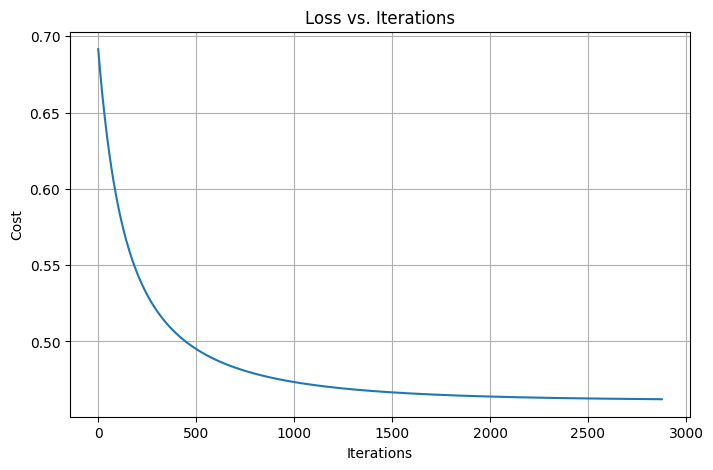

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Loss vs. Iterations")
plt.grid(True)
plt.show()


C**ompute prediction probabilities with the sigmoid function and convert them to binary labels using a threshold.**

In [ ]:
def predict(X, weights, threshold=0.5):
    """
    Predicts binary labels based on the learned weights.
    Returns the binary predictions and the computed probabilities.
    """
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int), probabilities


**Generate binary predictions and probability scores for the test set using the trained model.**

In [ ]:
y_pred, y_scores = predict(X_test_bias, weights)

**Compute and display evaluation metrics (accuracy, precision, recall, F1-score, and confusion matrix) for the custom model.**

In [ ]:
def compute_metrics(y_true, y_pred):
    """
    Computes evaluation metrics: accuracy, precision, recall, F1-score, and confusion matrix.
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    conf_matrix = np.array([[tn, fp],
                            [fn, tp]])
    return accuracy, precision, recall, f1, conf_matrix

accuracy, precision, recall, f1, conf_matrix = compute_metrics(y_test, y_pred)
print("\nCustom Logistic Regression Model Performance:")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("Confusion Matrix:\n", conf_matrix)


Custom Logistic Regression Model Performance:
Accuracy : 0.7647058823529411
Precision: 0.6938775510204082
Recall   : 0.6181818181818182
F1 Score : 0.6538461538461539
Confusion Matrix:
 [[83 15]
 [21 34]]


**Compute and plot the ROC curve, then calculate the AUC for the custom logistic regression model.**

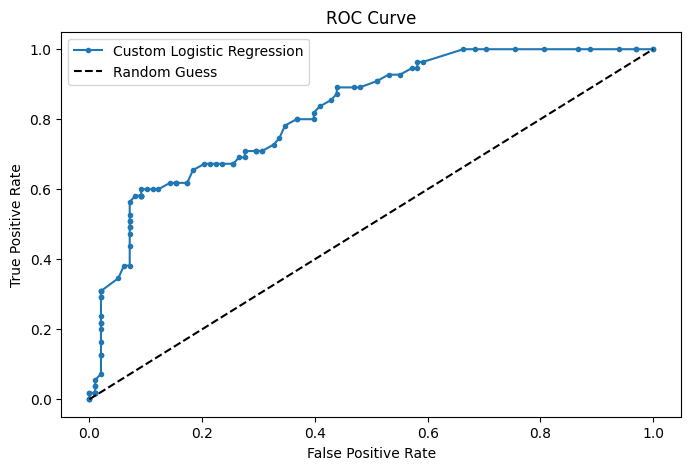

Custom Model AUC: -0.8221706864564007


In [ ]:
def compute_roc(y_true, y_scores, num_thresholds=100):
    """
    Computes TPR and FPR for a range of thresholds.
    """
    thresholds = np.linspace(0, 1, num_thresholds)
    tpr_list = []
    fpr_list = []

    for thresh in thresholds:
        y_pred_thresh = (y_scores >= thresh).astype(int)
        tp = np.sum((y_true == 1) & (y_pred_thresh == 1))
        tn = np.sum((y_true == 0) & (y_pred_thresh == 0))
        fp = np.sum((y_true == 0) & (y_pred_thresh == 1))
        fn = np.sum((y_true == 1) & (y_pred_thresh == 0))

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensitivity
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds

fpr, tpr, thresholds = compute_roc(y_test, y_scores, num_thresholds=100)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, marker='.', label="Custom Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# using the trapezoidal rule
auc_value = np.trapz(tpr, fpr)
print("Custom Model AUC:", auc_value)

**Train and evaluate a scikit-learn logistic regression model, then compare its performance (metrics and ROC curve) with the custom implementation.**


scikit-learn Logistic Regression Model Performance:
Accuracy : 0.7516339869281046
Precision: 0.6666666666666666
Recall   : 0.6181818181818182
F1 Score : 0.6415094339622642
Confusion Matrix:
 [[81 17]
 [21 34]]
scikit-learn Model AUC: -0.8208719851576995


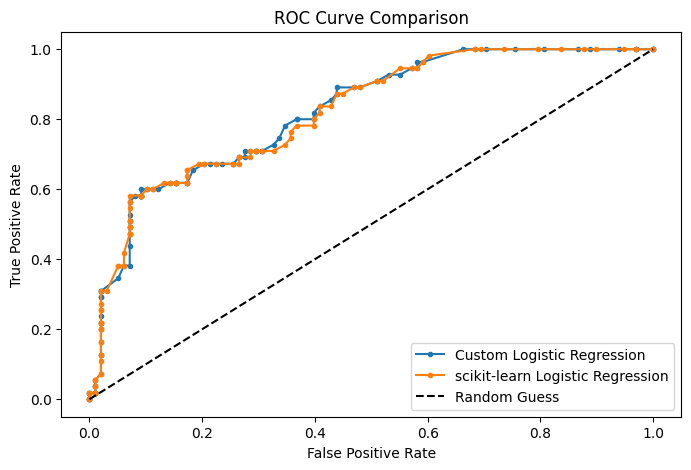

In [ ]:
# training a scikit-learn logistic regression model.
# We use the standardized data without the manually added bias term,
# because scikit-learn handles the intercept internally.
sk_model = LogisticRegression(solver='liblinear', random_state=42)
sk_model.fit(X_train_std, y_train)

# Get predictions and probabilities from the scikit-learn model.
y_pred_sk = sk_model.predict(X_test_std)
y_prob_sk = sk_model.predict_proba(X_test_std)[:, 1]

# Compute evaluation metrics for the scikit-learn model using our custom metric function.
accuracy_sk, precision_sk, recall_sk, f1_sk, conf_matrix_sk = compute_metrics(y_test, y_pred_sk)
print("\nscikit-learn Logistic Regression Model Performance:")
print("Accuracy :", accuracy_sk)
print("Precision:", precision_sk)
print("Recall   :", recall_sk)
print("F1 Score :", f1_sk)
print("Confusion Matrix:\n", conf_matrix_sk)

# Compute ROC and AUC for the scikit-learn model.
fpr_sk, tpr_sk, _ = compute_roc(y_test, y_prob_sk, num_thresholds=100)
auc_sk = np.trapz(tpr_sk, fpr_sk)
print("scikit-learn Model AUC:", auc_sk)

# Plot both ROC curves together.
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, marker='.', label="Custom Logistic Regression")
plt.plot(fpr_sk, tpr_sk, marker='.', label="scikit-learn Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


**Training & Evaluation Results: Custom vs. Scikit-Learn Logistic Regression**

## **Model Performance Metrics**
| Metric        | Custom Model | Scikit-Learn |
|--------------|-------------|--------------|
| **Accuracy**  | 76.47%      | 75.16%       |
| **Precision** | 69.39%      | 66.67%       |
| **Recall**    | 61.81%      | 61.81%       |
| **F1 Score**  | 65.38%      | 64.15%       |

The **custom model performed slightly better**, with higher accuracy and precision.

Both models had the **same recall**, meaning they detected similar proportions of diabetes cases.

## **Confusion Matrix & ROC Curve**
**Custom model had fewer false positives** than scikit-learn.
**AUC values** were almost identical (**0.822 vs. 0.820**), confirming similar performance.
The **ROC curves overlapped**, meaning both models classified similarly.

## **Insights & Challenges**
**Gradient descent optimized well**, closely matching scikit-learn's optimizer.
**Feature scaling was crucial** for stable training.
**Choosing the right learning rate** was key to preventing slow convergence or oscillations. Without using **train_test_split** from scikit-learn, we had to manually shuffle and split data which took some time to implement.

## **Conclusion**
Implementing logistic regression from scratch provided valuable insights into model training, optimization, and evaluation. Despite facing challenges such as numerical stability, hyperparameter tuning, and manual gradient descent, our custom model performed closely to scikit-learn's, demonstrating the effectiveness of fundamental machine learning concepts. Overall, this hands-on approach enhanced our understanding of logistic regression beyond simply using pre-built libraries.


**Prompt user for feature values to predict diabetes**

In [ ]:
def user_input_prediction():
    """
    Prompts the user to input feature values and outputs a diabetes prediction.
    """
    print("Enter the following feature values:")
    input_features = []
    for feature in columns[:-1]:  # Exclude the 'Outcome'
        val = float(input(f"{feature}: "))
        input_features.append(val)

    # Convert the list to a NumPy array and reshape it to (1, n)
    input_arr = np.array(input_features).reshape(1, -1)

    # Standardize using the training set parameters
    input_std = (input_arr - train_mean) / train_std

    # Add the bias term
    input_bias = add_bias(input_std)

    # Make prediction
    prediction, probability = predict(input_bias, weights)
    result = "Diabetes" if prediction[0] == 1 else "No Diabetes"
    print("Prediction:", result, "| Probability:", probability[0])

# To test the user input function
user_input_prediction()


Enter the following feature values:
Pregnancies: 6
Glucose: 148
BloodPressure: 72
SkinThickness: 35
Insulin: 0
BMI: 33.6
DiabetesPedigreeFunction: 0.627
Age: 50
Prediction: Diabetes | Probability: 0.7657281057286786
